In [1]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/bank-full.csv', sep=';')

In [4]:
filters = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

df = df[filters]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.y = (df.y == 'yes').astype(int)
    
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Q1

In [6]:
numerical = list(df_train.dtypes[df.dtypes != 'object'].index)
categorical  = list(df_train.dtypes[df.dtypes == 'object'].index)

In [7]:
numerical, categorical

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'])

In [8]:
dv = DictVectorizer(sparse=False)
scores=[]

for n in numerical:
    train_dict = df_train[[n]].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(max_iter=1000, random_state=1)
    model.fit(X_train, y_train)

    dicts_val = df_val[[n]].to_dict(orient='records')
    X_val = dv.transform(dicts_val)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))
    

In [9]:
pd.DataFrame(scores, columns=['feature', 'auc']).sort_values(by='auc', ascending=False)

,feature,auc
3,duration,0.796534
6,previous,0.607256
1,balance,0.599507
5,pdays,0.596250
4,campaign,0.576243
2,day,0.535220
0,age,0.501969


## Q2

In [10]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

dicts_val = df_val.to_dict(orient='records')
X_val = dv.transform(dicts_val)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred).round(3)

0.9

## Q3

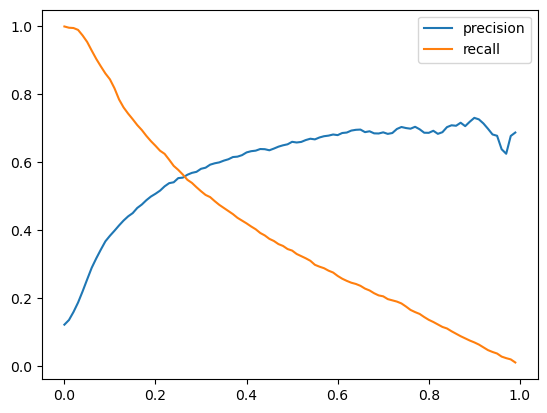

In [11]:
scores = []
thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((p * r) / (p + r))
    scores.append((t, tp, fp, fn, tn, p, r, f1))
    
df_scores = pd.DataFrame(data=scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1'])
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

In [12]:
df_scores['diff'] = abs(df_scores['precision'] - df_scores['recall'])

df_scores[df_scores['diff'] == df_scores['diff'].min()]

,threshold,tp,fp,fn,tn,precision,recall,f1,diff
26,0.26,619,497,479,7447,0.554659,0.563752,0.559169,0.009093


## Q4

In [13]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,precision,recall,f1,diff
22,0.22,686,611,412,7333,0.528913,0.624772,0.57286,0.095859


## Q5

In [14]:
from sklearn.model_selection import KFold

In [15]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model
    
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X =  dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train['y']
    del df_val['y']
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('%f' % np.std(scores))

0.005497


## Q6

In [31]:
from tqdm.auto import tqdm

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        del df_train['y']
        del df_val['y']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s\t%.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06	0.701 +- 0.009
C=0.001	0.861 +- 0.007
C=1	0.906 +- 0.005
